In [11]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [35]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 128

x_dim  = 224*224
hidden_dim = 512
latent_dim = 256

lr = 1e-4

epochs = 5000

In [13]:
class CustomDataset(Dataset):

    def __init__(self, df, transform=None):
        value_counts = df['id'].value_counts()
        values_to_keep = value_counts[(value_counts >= 5) & (value_counts <= 10)].index
        df = df[df['id'].isin(values_to_keep)]
        df['id'] = pd.factorize(df['caption'])[0]
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # label = self.df['id'].iloc[idx]
        emb = self.df["emb"].iloc[idx]
        emb = torch.load("../pipeline/"+emb).squeeze()
        
        img = Image.open("../cocodata/"+str(self.df['image'].iloc[idx]))
        if self.transform:
            img = self.transform(img)

        return img, emb

###    Step 1. Load (or download) Dataset

In [14]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# mnist_transform = transforms.Compose([
#         transforms.ToTensor(),
# ])

kwargs = {'num_workers': 1, 'pin_memory': True} 

# train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
# test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
tf = transforms.Compose([transforms.Grayscale(), transforms.Resize((224,224)), transforms.ToTensor()])
train_dataset = CustomDataset(pd.read_csv("../captions.csv"), transform=tf)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

/tmp/ipykernel_12696/2392053360.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = pd.factorize(df['caption'])[0]


### Step 2. Define our model: Variational AutoEncoder (VAE)

In [15]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_input3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        h_       = self.LeakyReLU(self.FC_input3(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [16]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        h     = self.LeakyReLU(self.FC_hidden3(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [17]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [18]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [19]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [38]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(x.size()[0], x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  28385.50034516433
	Epoch 2 complete! 	Average Loss:  28380.18568999192
	Epoch 3 complete! 	Average Loss:  28376.538490032326
	Epoch 4 complete! 	Average Loss:  28374.558905239763
	Epoch 5 complete! 	Average Loss:  28372.473725417563
	Epoch 6 complete! 	Average Loss:  28369.774927599676
	Epoch 7 complete! 	Average Loss:  28370.171403556036
	Epoch 8 complete! 	Average Loss:  28370.326542295257
	Epoch 9 complete! 	Average Loss:  28369.472083782326
	Epoch 10 complete! 	Average Loss:  28369.315446524786
	Epoch 11 complete! 	Average Loss:  28382.740781586745
	Epoch 12 complete! 	Average Loss:  28380.527773100755
	Epoch 13 complete! 	Average Loss:  28371.124486462824
	Epoch 14 complete! 	Average Loss:  28364.382787244074
	Epoch 15 complete! 	Average Loss:  28366.323326373924
	Epoch 16 complete! 	Average Loss:  28362.053214237607
	Epoch 17 complete! 	Average Loss:  28372.914752828663
	Epoch 18 complete! 	Average Loss:  28367.733086947737

### Step 5. Generate images from dataset

In [39]:
import matplotlib.pyplot as plt

In [40]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/59 [00:00<?, ?it/s]


In [41]:
def show_image(x, idx):
    x = x.view(batch_size, 224, 224)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

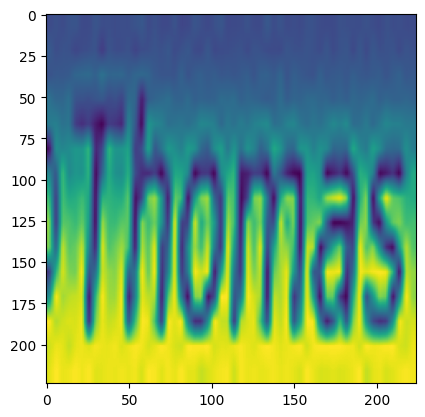

In [42]:
show_image(x, idx=0)

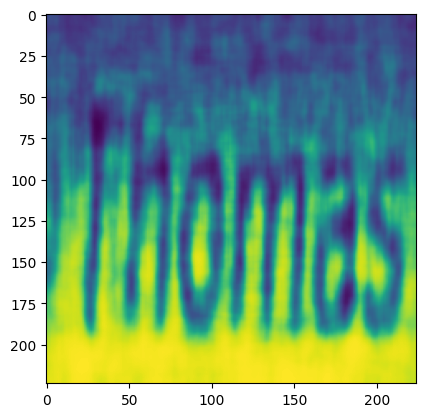

In [43]:
show_image(x_hat, idx=0)

In [53]:
torch.save(model.state_dict(), "vae.pt")